In [4]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import os
import nbformat
import plotly.express as px

from fbprophet import Prophet

In [5]:
df = pd.read_csv('https://raw.githubusercontent.com/srivatsan88/YouTubeLI/master/dataset/nyc_energy_consumption.csv')

In [6]:
df.head()

,timeStamp,demand,precip,temp
0,2012-01-01 00:00:00,4937.5,0.0,46.13
1,2012-01-01 01:00:00,4752.1,0.0,45.89
2,2012-01-01 02:00:00,4542.6,0.0,45.04
3,2012-01-01 03:00:00,4357.7,0.0,45.03
4,2012-01-01 04:00:00,4275.5,0.0,42.61


In [7]:
df['timeStamp'] = pd.to_datetime(df['timeStamp'])
# demand missing from 2017-08-10
df = df[df['timeStamp']<'2017-08-10']

In [8]:
print("Data types: \n", df.dtypes)
print ("\n Missing values: \n", df.isnull().sum())
print("\n N rows: \n", df.shape[0])
print("\n Time from ", df['timeStamp'].min(), " to ", df['timeStamp'].max())

Data types: 
 timeStamp    datetime64[ns]
demand              float64
precip              float64
temp                float64
dtype: object

 Missing values: 
 timeStamp      0
demand        32
precip       230
temp         186
dtype: int64

 N rows: 
 49150

 Time from  2012-01-01 00:00:00  to  2017-08-09 23:00:00


In [9]:
# ALL DATETIMES
idx = pd.date_range(start = '2012-01-01 00:00:00', end = '2017-08-09 23:00:00', freq='H')
print(len(idx))
idx

49152


DatetimeIndex(['2012-01-01 00:00:00', '2012-01-01 01:00:00',
               '2012-01-01 02:00:00', '2012-01-01 03:00:00',
               '2012-01-01 04:00:00', '2012-01-01 05:00:00',
               '2012-01-01 06:00:00', '2012-01-01 07:00:00',
               '2012-01-01 08:00:00', '2012-01-01 09:00:00',
               ...
               '2017-08-09 14:00:00', '2017-08-09 15:00:00',
               '2017-08-09 16:00:00', '2017-08-09 17:00:00',
               '2017-08-09 18:00:00', '2017-08-09 19:00:00',
               '2017-08-09 20:00:00', '2017-08-09 21:00:00',
               '2017-08-09 22:00:00', '2017-08-09 23:00:00'],
              dtype='datetime64[ns]', length=49152, freq='H')

In [10]:
df = df.set_index('timeStamp')
print(df.shape)
df = df.reindex(idx)
print(df.shape)

(49150, 3)
(49152, 3)


In [11]:
# Filling missing values with fill forward
for col in df.columns:
    df[col] = df[col].fillna(method='ffill')

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

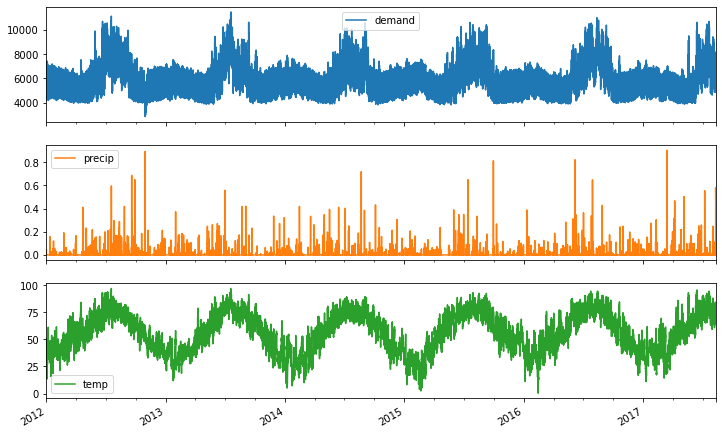

In [12]:
df.plot(subplots=True, figsize = (12,8))

<AxesSubplot:>

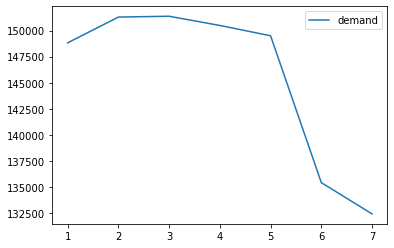

In [13]:
df_daily = df[['demand']].resample('D').sum()
df_daily.groupby(df_daily.index.dayofweek+1).mean().plot()

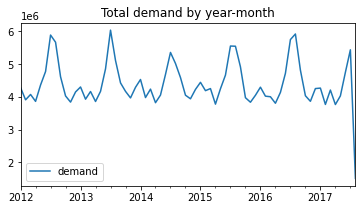

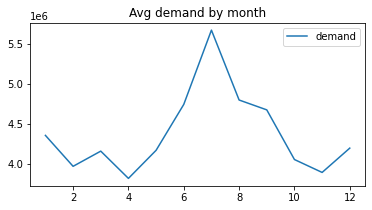

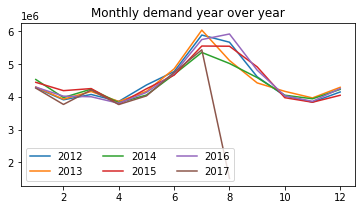

In [14]:
temp = df[['demand']].resample('1m').sum()
temp.plot(title = "Total demand by year-month", figsize = (6,3))
temp.groupby(temp.index.month).mean().plot(title="Avg demand by month", figsize = (6,3))
#plt.clf()

# Year over year
temp['month'] = temp.index.month
temp['year'] = temp.index.year
fig, ax = plt.subplots(figsize=(6,3))
for key, grp in temp.groupby('year'):
    ax.plot(grp['month'], grp['demand'], label = key)
plt.legend(loc='lower left', ncol = 3)
plt.title("Monthly demand year over year")
plt.show()

In [15]:
df_daily = df[['demand', 'precip']].resample('D').sum()
temp = df.groupby(df.index.date)['temp'].agg(min_temp = 'min', max_temp = 'max', avg_temp = 'mean')
df_daily = df_daily.join(temp)
df_daily.head()

,demand,precip,min_temp,max_temp,avg_temp
2012-01-01,118916.0,0.0597,38.78,50.77,46.510000
2012-01-02,127270.9,0.0000,33.57,49.78,40.496667
2012-01-03,146292.3,0.0000,16.47,33.14,26.672500
2012-01-04,152070.4,0.0000,13.40,31.83,20.585000
2012-01-05,147125.9,0.0000,27.31,39.16,33.577500


In [16]:
df_daily.describe()

,demand,precip,min_temp,max_temp,avg_temp
count,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000
mean,145621.502439,0.085240,49.117979,62.110894,55.480255
std,23394.246407,0.220609,16.827618,17.797282,17.107129
min,87914.300000,0.000000,0.330000,15.620000,9.015000
25%,130886.425000,0.000000,35.935000,47.222500,41.514896
50%,138568.571000,0.000000,49.205000,63.040000,56.011458
75%,154761.140500,0.043700,64.312500,77.715000,71.287604
max,243918.700000,2.716900,83.230000,97.260000,89.606667


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

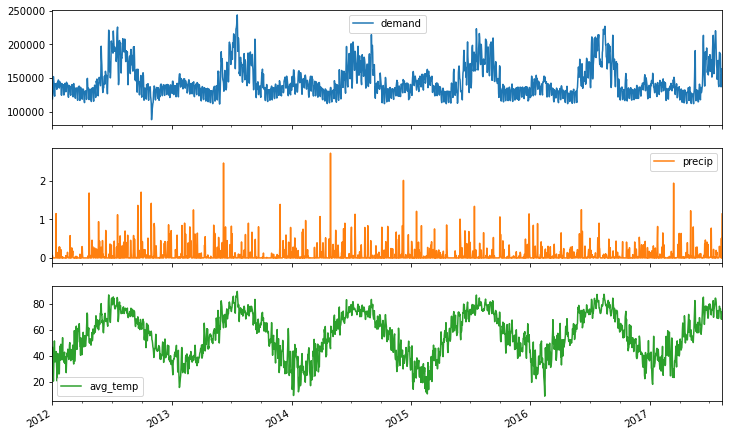

In [17]:
df_daily[['demand', 'precip', 'avg_temp']].plot(subplots = True, figsize = (12,8))

In [18]:
df_daily[(df_daily['demand']==df_daily['demand'].min())|(df_daily['demand']==df_daily['demand'].max())]

,demand,precip,min_temp,max_temp,avg_temp
2012-10-30,87914.3,0.2354,52.42,60.74,57.019167
2013-07-19,243918.7,0.0000,83.23,95.78,89.606667


In [19]:
df_daily[['demand','precip', 'avg_temp']].corr()

,demand,precip,avg_temp
demand,1.000000,0.031745,0.561222
precip,0.031745,1.000000,0.006535
avg_temp,0.561222,0.006535,1.000000


In [117]:
'''
precip
0.50	0.000000
0.75	0.043700
0.90	0.282380
0.95	0.515005
0.99	1.037075'''

'\nprecip\n0.50\t0.000000\n0.75\t0.043700\n0.90\t0.282380\n0.95\t0.515005\n0.99\t1.037075'

In [118]:
df_daily[df_daily['precip']>0.28][['demand','precip', 'avg_temp']].corr()


,demand,precip,avg_temp
demand,1.000000,-0.037503,0.679025
precip,-0.037503,1.000000,-0.054966
avg_temp,0.679025,-0.054966,1.000000


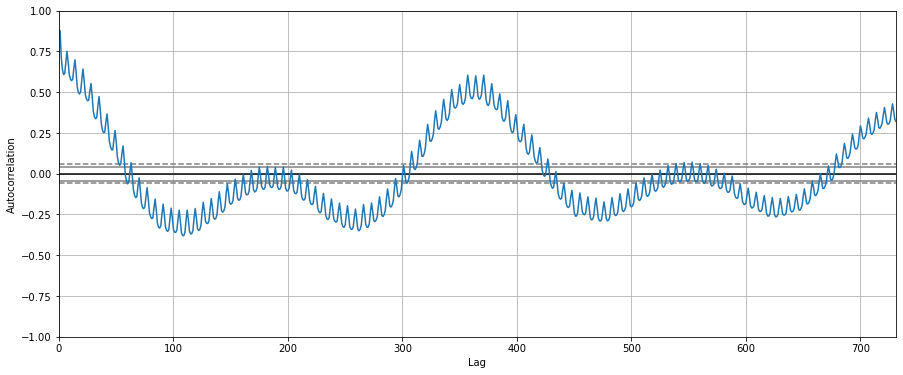

In [21]:
fig = plt.figure(figsize=(15,6))
ax = pd.plotting.autocorrelation_plot(df_daily['demand'])
ax.set_xlim([0,731])
plt.show()
                                

# Forecasting with Prophet

In [169]:
data = df_daily.reset_index().rename(columns={'index': 'ds', 'demand':'y'})
data['temp_80'] = np.where(data['avg_temp']>80,1,0)  #5% quantile
data['temp_26'] = np.where(data['avg_temp']<26,1,0)  #95% quantile
data['month'] = data['ds'].dt.month
data['season'] = np.floor(data['month']/3).astype('int')
data['season'] = np.where(data['season']==4, 0, data['season'])
data

,ds,y,precip,min_temp,max_temp,avg_temp,temp_80,temp_26,month,season
0,2012-01-01,118916.000,0.0597,38.78,50.77,46.510000,0,0,1,0
1,2012-01-02,127270.900,0.0000,33.57,49.78,40.496667,0,0,1,0
2,2012-01-03,146292.300,0.0000,16.47,33.14,26.672500,0,0,1,0
3,2012-01-04,152070.400,0.0000,13.40,31.83,20.585000,0,1,1,0
4,2012-01-05,147125.900,0.0000,27.31,39.16,33.577500,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
2043,2017-08-05,159779.923,0.1351,68.05,80.39,74.172917,0,0,8,2
2044,2017-08-06,136856.677,0.0000,60.96,78.62,70.129167,0,0,8,2
2045,2017-08-07,153555.700,0.5096,65.66,70.86,68.203750,0,0,8,2
2046,2017-08-08,155319.025,0.0000,66.17,79.24,71.039167,0,0,8,2


In [170]:
# DATA OVERVIEW
fig = px.line(data, x = 'ds',y = 'y',title = 'NYC_Energy_Consumption', hover_data=['avg_temp','month'])

fig.update_xaxes(
    rangeslider_visible= True,
    rangeselector=dict(
                        buttons = list([
                        dict(count = 1,label = '1m',step='month',stepmode = "backward"),
                        dict(count = 2,label = '6m',step='month',stepmode = "backward"),
                        dict(count = 3,label = '6mYTD',step='month',stepmode = "todate"),
                        dict(count = 4,label = '2y',step='year',stepmode = "backward"),
                        dict(count = 5,label = '3y',step='year',stepmode = "backward"),
                        dict(step= 'all')
                            ])        
                        )
                   )
fig.show()

In [171]:
print(data[['precip']].quantile([0.5, 0.75, 0.9, 0.95, 0.99]))
print(data[['avg_temp']].quantile([0.01, 0.03, 0.05, 0.1, 0.9, 0.95, 0.97, 0.99]))

        precip
0.50  0.000000
0.75  0.043700
0.90  0.282380
0.95  0.515005
0.99  1.037075
       avg_temp
0.01  18.274671
0.03  24.006954
0.05  26.917354
0.10  32.454417
0.90  76.958333
0.95  79.852354
0.97  81.569979
0.99  84.317229


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


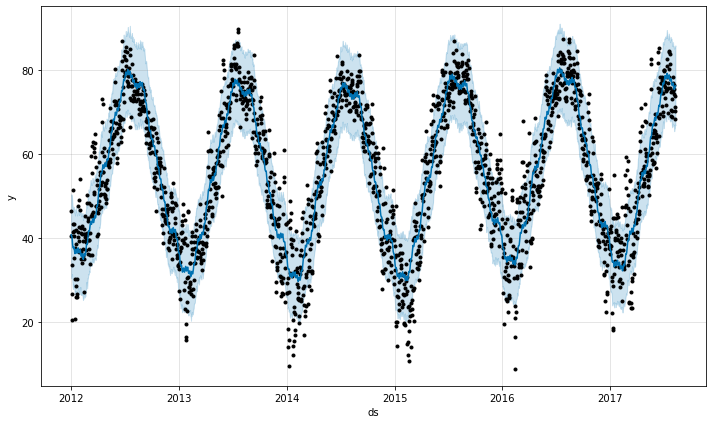

In [172]:
# ABNORMAL TEMP
temp = df_daily['avg_temp'].reset_index().rename(columns={'index': 'ds', 'avg_temp':'y'})
m = Prophet(interval_width = 0.85)
m.fit(temp)
fcst = m.predict(temp)
fig11=m.plot(fcst)
#df_daily[['avg_temp']].plot(figsize=(12,6))

In [173]:
temp=fcst[['yhat_lower', 'yhat_upper', 'ds']]
data = data.merge(temp, on = 'ds')
data['temp_low'] = pd.to_numeric(data['avg_temp']<data['yhat_lower']).astype('int')
data['temp_high'] = pd.to_numeric(data['avg_temp']>data['yhat_upper']).astype('int')
data = data.drop(['yhat_lower', 'yhat_upper'], axis=1)
data.head()

,ds,y,precip,min_temp,max_temp,avg_temp,temp_80,temp_26,month,season,temp_low,temp_high
0,2012-01-01,118916.0,0.0597,38.78,50.77,46.510000,0,0,1,0,0,0
1,2012-01-02,127270.9,0.0000,33.57,49.78,40.496667,0,0,1,0,0,0
2,2012-01-03,146292.3,0.0000,16.47,33.14,26.672500,0,0,1,0,1,0
3,2012-01-04,152070.4,0.0000,13.40,31.83,20.585000,0,1,1,0,1,0
4,2012-01-05,147125.9,0.0000,27.31,39.16,33.577500,0,0,1,0,0,0


In [174]:
train = data[data['ds']<='2017-06-30']
test = data[data['ds']>'2017-06-30']
print('Train shape:', train.shape)
print('Test shape:', test.shape)

Train shape: (2008, 12)
Test shape: (40, 12)


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


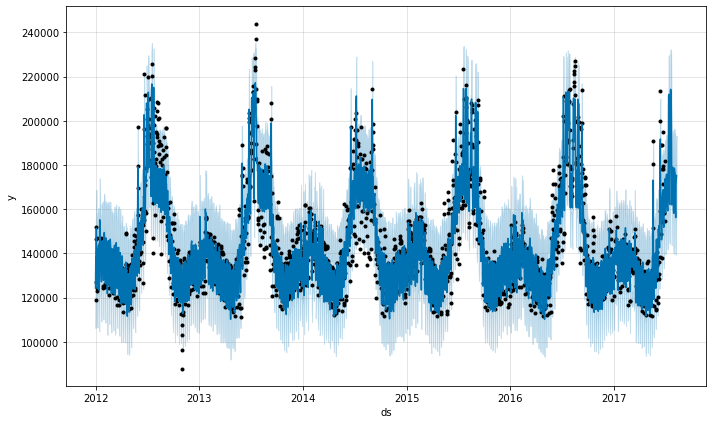

In [175]:
m_prophet = Prophet(interval_width = 0.95, yearly_seasonality = True, weekly_seasonality=True)

m_prophet.add_country_holidays(country_name='US')
m_prophet.add_regressor('avg_temp', standardize = False)
#m_prophet.add_regressor('max_temp', standardize = False)
#m_prophet.add_regressor('min_temp', standardize = False)
#m_prophet.add_regressor('precip', standardize = False)
m_prophet.add_regressor('temp_80', standardize = False)
m_prophet.add_regressor('temp_26', standardize = False)
m_prophet.add_regressor('season', standardize = False)
m_prophet.add_regressor('temp_low', standardize = False)
m_prophet.add_regressor('temp_high', standardize = False)

m_prophet.fit(train)
future = m_prophet.make_future_dataframe(periods=test.shape[0])
cols = data.columns.drop(['ds', 'y'])
for col in cols:
    future[col] = data[col]

forecast = m_prophet.predict(future)
#forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

fig1 = m_prophet.plot(forecast)
#95% Confidence interval is the light blue color
#the black dots are actual values 
#the dark blue is the y_hat or forecasted value

In [176]:
res = pd.concat([test['y'], forecast['yhat'][-40:]], axis = 1)
RMSE_prophet = np.sqrt(((res['y']-res['yhat'])**2).mean())
MAPE_prophet = (abs(res['y']-res['yhat'])/res['y']).mean()
print('RMSE Prophet', RMSE_prophet)
print('MAPE Prophet', MAPE_prophet)
# Univariate 19092.70
# US Holidays 19185.85
# Avg temp 17815.42
# Max temp 17970.67
# Min temp 17925.87
# Precip 18040.57
# -Holidays, precip 17990.70
# -Min temp 17946.32
# -Max temp 17954.94
# Holidays & max temp 17968.82
# Holidays & avg temp 17815.42
# Temp 80 12743.99
# Month 12822.767 -
# Season 3 bins 12741.39 -
# Season 4 bins 12751.81 -
# Holidays, avg_temp, temp_80, temp_20 12581.22
# Holidays, avg_temp, temp_low, temp_high 17952.67
# Holidays, avg_temp, temp_79, temp_27 12494.44
# Holidays, avg_temp, temp_80, temp_26, temp_low, temp_high, season 11650.25 (temperature interval width 0.85, temp 80&26)

RMSE Prophet 11821.94292011595
MAPE Prophet 0.05822660530642946
